# Esquema de la arquitectura del Modelo

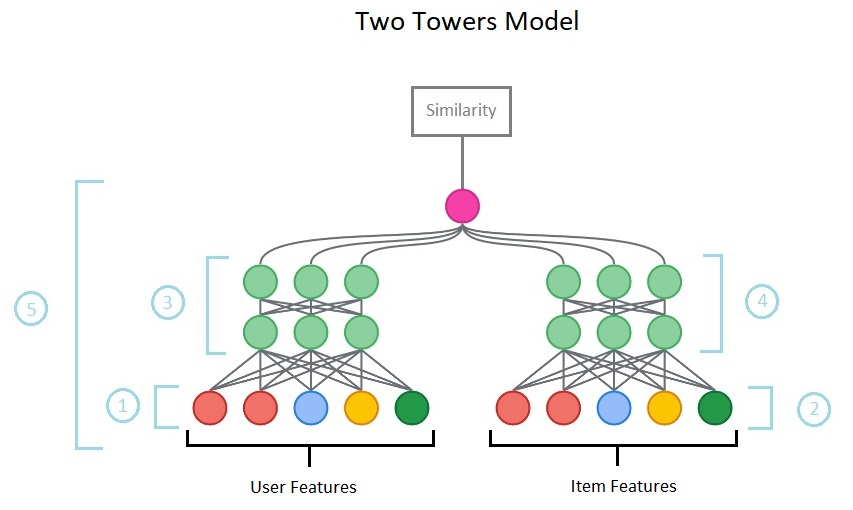

Referencias:

1. Capa de embedding para la features del usuario.
2. Capa de embeddings para las features de los items a recomendar.
3. Query Model: Modelo para entrenar las features del usuario.
4. Candidate model: Modelo para entrenar las features de los items a recomendar.
5. Full Model: Wrapping model de 1, 2, 3 y 4.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

In [ ]:
import os
import tempfile

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

plt.style.use('seaborn-whitegrid')

# 1 - Capa de embedding para la features del usuario

In [ ]:
# Model for embedding user queries.
class UserModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])
    self.timestamp_embedding = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Discretization(timestamp_buckets.tolist()),
        tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
    ])
    self.normalized_timestamp = tf.keras.layers.experimental.preprocessing.Normalization() 

    self.normalized_timestamp.adapt(timestamps)

  def call(self, inputs):
   
    return tf.concat([
        self.user_embedding(inputs["user_id"]),
        self.timestamp_embedding(inputs["discount_name"]),
        self.normalized_timestamp(inputs["discount_category"]),
    ], axis=1)4.86 ms ± 21.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

# 3 - Query Model: Modelo para entrenar las features del usuario.

In [ ]:
# Model for training user queries.
class QueryModel(tf.keras.Model):
  """Model for encoding user queries."""

  def __init__(self, layer_sizes):
    """Model for encoding user queries.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    # We first use the user model for generating embeddings.
    self.embedding_model = UserModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))
    
  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

# 2 - Capa de embeddings para las features de los items a recomendar.

In [ ]:
# Model for embedding discounts.
class DiscountModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.title_embedding = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
          vocabulary=unique_discounts_titles,mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32)
    ])

    self.title_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=max_tokens)

    self.discounts_text_embedding = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(discounts)

  def call(self, titles):
    return tf.concat([
        self.discounts_embedding(discounts),
        self.discounts_text_embedding(discounts),
    ], axis=1)

# 4 - Candidate model: Modelo para entrenar las features de los items a recomendar.

In [ ]:
# Model for training Discounts.
class CandidateModel(tf.keras.Model):
  """Model for encoding discounts."""

  def __init__(self, layer_sizes):
    """Model for encoding discounts.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    self.embedding_model = FullModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))
    
  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

# 5 - Full Model

In [ ]:
# Full model (wrapper up model).

class FullModel(tfrs.models.Model):

  def __init__(self, layer_sizes):
    super().__init__()
    self.query_model = QueryModel(layer_sizes)
    self.candidate_model = CandidateModel(layer_sizes)
    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=discountss.batch(128).map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):

     query_embeddings = self.query_model({
        "user_id": features["user_id"],
        "timestamp": features["timestamp"],
    })
    discounts_embeddings = self.candidate_model(features["discount_name"])

    return self.task(
        query_embeddings, discounts_embeddings, compute_metrics=not training)

# Training Routine.

In [ ]:
num_epochs = 100

model = FullModel([32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1)

accuracy = one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

# Evaluación

In [ ]:
model.evaluate(cached_test, return_dict=True)

# Predicción

In [ ]:
# Se crea un modelo que toma los ID's del usuario y recomienda descuentos.
scann_index = tfrs.layers.factorized_top_k.ScaNN(model.user_model)
scann_index.index(discounts.batch(100).map(model.discounts_model), discounts)

 
simililarity_score, id_de_descuentos = scann_index(tf.constant(["42"]))

# Serving

In [ ]:
# Guardamos el modelo.
with tempfile.TemporaryDirectory() as tmp:
  path = os.path.join(tmp, "model")

  
  scann_index.save(
      path,
      options=tf.saved_model.SaveOptions(namespace_whitelist=["Scann"])
  )

  # Lo cargamos
  loaded = tf.keras.models.load_model(path)

  # Hacemos inferencia, a modo de ejemplo, para el user con ID: 42
  simililarity_score, id_de_descuentos = loaded(["42"])

